## 00. Import libraries and load data

Note: This Jupyter Notebook was created as part of the group work. Each member has contributed similarly to the result.

In [15]:
# First we import all neccessary libraries and give some of them an alias for easy access
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from sklearn.base import clone
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## 1. Read in the data

In [16]:
# Read in the data so every group member can run the notebook on his machine
# (our repo is on github, we therefore have the same file structure)
df = pd.read_csv("../../Data/Transformed/Leo/inventory_management_cleaned_transformed_unscaled_with_labels.csv")
df.shape # Get a first idea about the number of rows and columns of the dataset

(1722, 11)

In [17]:
# We define that y equals the attribute we want to predict and X equals all the other attributes to predict y 
y = df["Clusterlabel"]
X = df.loc[:, ~df.columns.isin(['Clusterlabel', 'Product_UID'])]

In [18]:
# We check if y equals the attribute we want to predict (salary)
y

0       0
1       0
2       0
3       0
4       1
       ..
1717    1
1718    0
1719    0
1720    1
1721    1
Name: Clusterlabel, Length: 1722, dtype: int64

In [19]:
# We check if X equals all other attributes than salary to predict this attribute 
X

,Category,Region,Inventory Level,Price,Discount,Weather Condition,Promotion,Demand,Weekday
0,1,1,195,72.72,5,1,0,115,2
1,0,1,117,80.16,15,1,1,229,2
2,0,1,247,62.94,10,1,1,157,2
3,1,1,139,87.63,10,1,0,52,2
4,3,1,152,54.41,0,1,0,59,2
...,...,...,...,...,...,...,...,...,...
1717,3,1,129,62.83,10,0,0,143,5
1718,2,1,104,98.97,10,0,1,54,5
1719,2,1,494,111.25,10,0,0,70,5
1720,3,2,625,69.62,5,1,0,69,5


# 2. Split the data with Split Validation

In [20]:
# We check the imbalance of the data set to get further information for potential data augmentation techniques
y.value_counts()

Clusterlabel
1    930
0    792
Name: count, dtype: int64

In [21]:
# We split our Data into test and train Data so we can later train on the train data and measure the performance on the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape
print("Before:", Counter(y_train))

Before: Counter({1: 638, 0: 515})


## 2.1. Gini - No SMOTE

In [22]:
# We run different trees with different paramaters and store the ones with the best accuracy. We use for loops to iterate through all combinations
# We store the best params to use them for further analysis 
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [2, 3, 4, 5]

best_score = 0
best_params_gini = {}

for depth in max_depth:
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            dt_gini = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
            dt_gini.fit(X_train, y_train)
            y_pred_gini = dt_gini.predict(X_test)
            acc = accuracy_score(y_test, y_pred_gini)

            #print(f"max_depth = {depth}, min_samples_split = {split}, min_samples_leaf = {leaf} -> Accuracy = {acc:.4f}")

            if acc > best_score:
                best_score = acc
                best_params_gini = {
                    'max_depth': depth,
                    'min_samples_split': split,
                    'min_samples_leaf': leaf
                }

print(f"\nBest parameters: {best_params_gini} with accuracy: {best_score}")


Best parameters: {'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 2} with accuracy: 1.0


In [23]:
# We build the tree and calculate the accuracy based on the best paramters we have derived for the gini tree
dt_gini = DecisionTreeClassifier(criterion='gini', splitter='best', **best_params_gini, random_state=42)
dt_gini.fit(X_train, y_train)
y_pred_gini = dt_gini.predict(X_test)
accuracy_test_gini_nosmote = accuracy_score(y_test, y_pred_gini)
print(accuracy_test_gini_nosmote)

1.0


In [24]:
# We want to check wether our model is robust or if it is dependant on the data. The only way to check this for split validation, is to 
# evaluate the accuracy based on the train data and compare the results with the accuracy of the test data. If they
# deviate less than 5%, the model is independant of the underlying data and thus is robust
y_pred_train_gini = dt_gini.predict(X_train)
accuracy_train_gini_nosmote = accuracy_score(y_train, y_pred_train_gini)
print(accuracy_train_gini_nosmote)
if abs(accuracy_test_gini_nosmote-accuracy_train_gini_nosmote) < (0.05*accuracy_test_gini_nosmote): 
    print("Passed the Robustness Check!")
else: 
    print("Didn't pass the Robustness Check!")

1.0
Passed the Robustness Check!


[Text(0.5, 0.75, 'Category <= 2.5\ngini = 0.494\nsamples = 1153\nvalue = [515, 638]\nclass = 1'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 515\nvalue = [515, 0]\nclass = 0'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 638\nvalue = [0, 638]\nclass = 1'),
 Text(0.625, 0.5, '  False')]

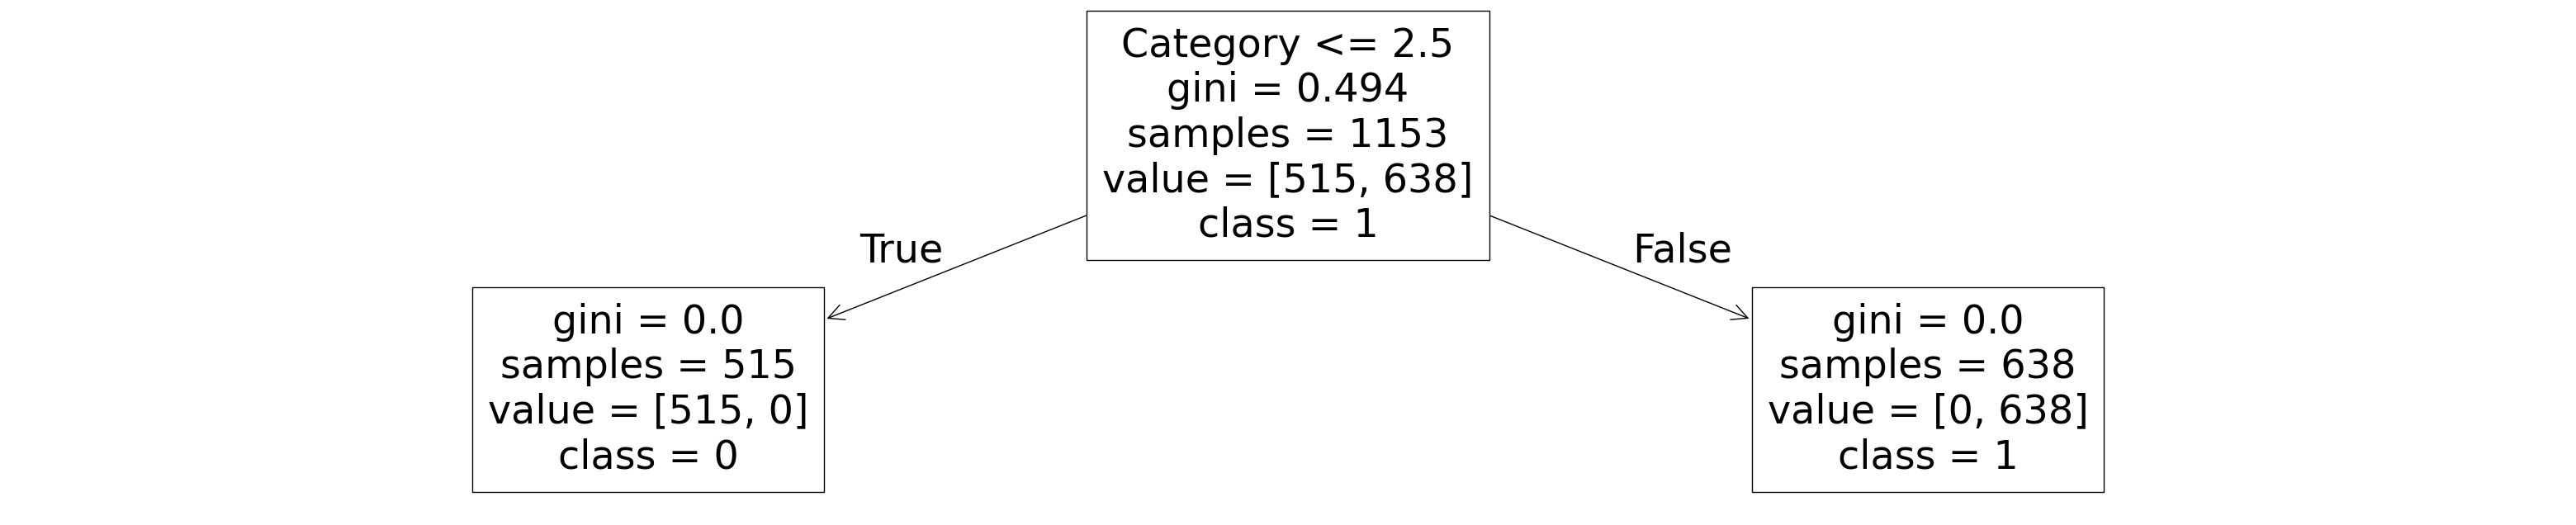

In [25]:
# We plot the decision tree to check if our model is interpretable. 
feature_names = X_train.columns
plt.figure(figsize=(40,8))
tree.plot_tree(dt_gini.fit(X_train, y_train),feature_names=feature_names, class_names=['0', '1'])

In [26]:
# We can also get our rules in textual format
feature_names = X_train.columns
text_representation = tree.export_text(dt_gini, feature_names=feature_names)
print(text_representation)

|--- Category <= 2.50
|   |--- class: 0
|--- Category >  2.50
|   |--- class: 1



Text(0.5, 1.0, 'Confusion Matrix')

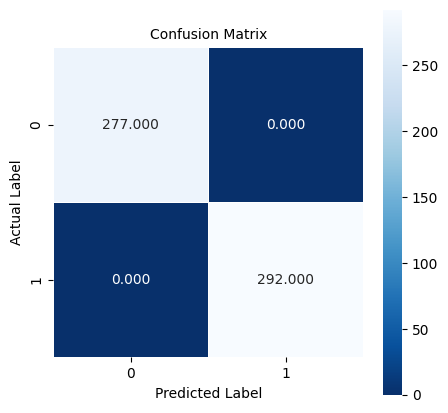

In [27]:
# We use the confusion matrix to visualize the performance of our classifier.
# It helps us understand how well the model distinguishes between the classes,
# showing the number of correct and incorrect predictions for each class.
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_gini)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square=True, cmap="Blues_r")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size = 10)

In [28]:
# We analyze the classification report to get further insights into the performance of our model
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       292

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569

